## Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting the data

In [0]:
# ! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [0]:
! cp kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle datasets download nikitarom/planets-dataset

 99% 1.49G/1.50G [00:18<00:00, 102MB/s] 
100% 1.50G/1.50G [00:18<00:00, 88.4MB/s]


In [0]:
!unzip \planets-dataset.zip

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [0]:
df = pd.read_csv('/content/planet/planet/train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
path = '/content/planet/planet'

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv( path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

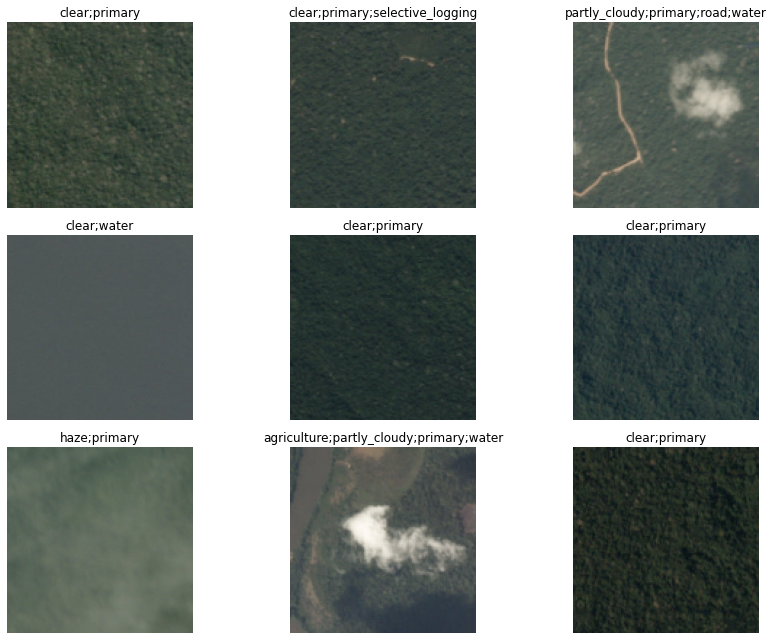

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


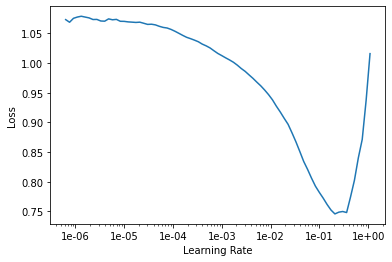

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.139414,0.116817,0.942317,0.899654,02:27
1,0.111718,0.100480,0.950114,0.910637,02:27
2,0.099735,0.092575,0.956124,0.919442,02:25
3,0.095279,0.088320,0.954278,0.923752,02:25
4,0.094963,0.087422,0.956451,0.923837,02:25


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


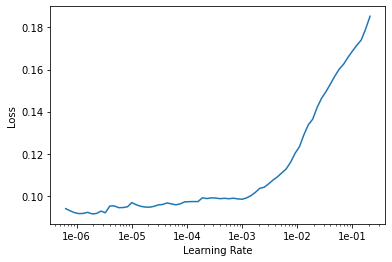

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096918,0.091365,0.951721,0.919465,02:33
1,0.099695,0.089377,0.950398,0.921313,02:33
2,0.089800,0.085929,0.955790,0.927136,02:32
3,0.081621,0.083678,0.958871,0.928907,02:32
4,0.082456,0.082795,0.959561,0.929233,02:32


In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


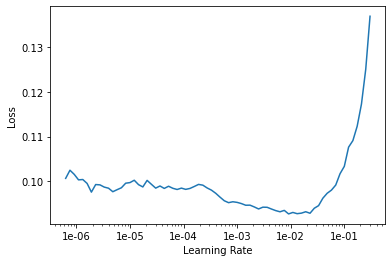

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087605,0.087670,0.957533,0.922190,04:31
1,0.088789,0.084918,0.956756,0.927903,04:32
2,0.086975,0.082570,0.957490,0.928054,04:34
3,0.080479,0.081818,0.959452,0.930033,04:30
4,0.082099,0.081400,0.959445,0.930536,04:30


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086095,0.083177,0.957708,0.928414,04:46
1,0.088069,0.085114,0.954816,0.923686,04:48
2,0.082784,0.083375,0.958035,0.927032,04:50
3,0.078640,0.081396,0.959387,0.929963,04:48
4,0.076970,0.081351,0.959518,0.929653,04:48


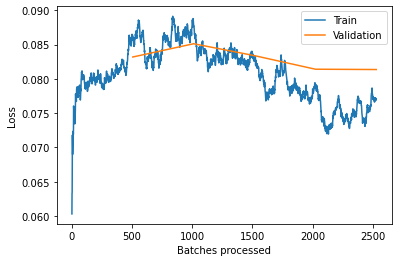

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [0]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [0]:
test = ImageList.from_folder('/content/planet/planet/test-jpg').add(ImageList.from_folder('/content/planet/planet/test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['clear primary',
 'agriculture clear primary road',
 'clear primary',
 'clear primary',
 'agriculture clear cultivation primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv('/content/planet/planet/submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {'/content/planet/planet/submission.csv'} -m "My submission"

100% 2.20M/2.20M [00:02<00:00, 898kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)